/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow Version: 2.12.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

  IMPROVED TIRE QUALITY CLASSIFIER
  SE-MobileNetV2 + TFRecord Pipeline
  Target: 90%+ Test Accuracy

Author: Sar-Hal
Date: 2025-10-25

PREPARING DATA WITH TFRECORDS

Dataset Statistics:
  Defective tires: 1028
  Good tires: 828
  Total: 1856
  Class balance: 0.81:1 (good:defective)

Data Split:
  Training: 1299 images (70.0%)
  Validation: 278 images (15.0%)
  Test: 279 images (15.0%)

Creating TFRecord files...


Training set: 100%|██████████| 1299/1299 [00:28<00:00, 45.70it/s]


✓ Created: tfrecords/train.tfrecord (1299 images)


Validation set: 100%|██████████| 278/278 [00:05<00:00, 53.70it/s]


✓ Created: tfrecords/val.tfrecord (278 images)


Test set: 100%|██████████| 279/279 [00:05<00:00, 50.94it/s]


✓ Created: tfrecords/test.tfrecord (279 images)

Class Weights (for imbalanced data):
  Defective (0): 0.886
  Good (1): 1.148

BUILDING SE-MOBILENETV2 MODEL
9406464/9406464 [==============================] - 0s 0us/step

Fine-tuning strategy:
  Total base model layers: 154
  Frozen layers: 84
  Trainable layers: 70

Model Architecture:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 se_block (SEBlock)          (None, 8, 8, 1280)        819200    
                                                                 
 global_average_pooling2d (G  (None, 1280)          

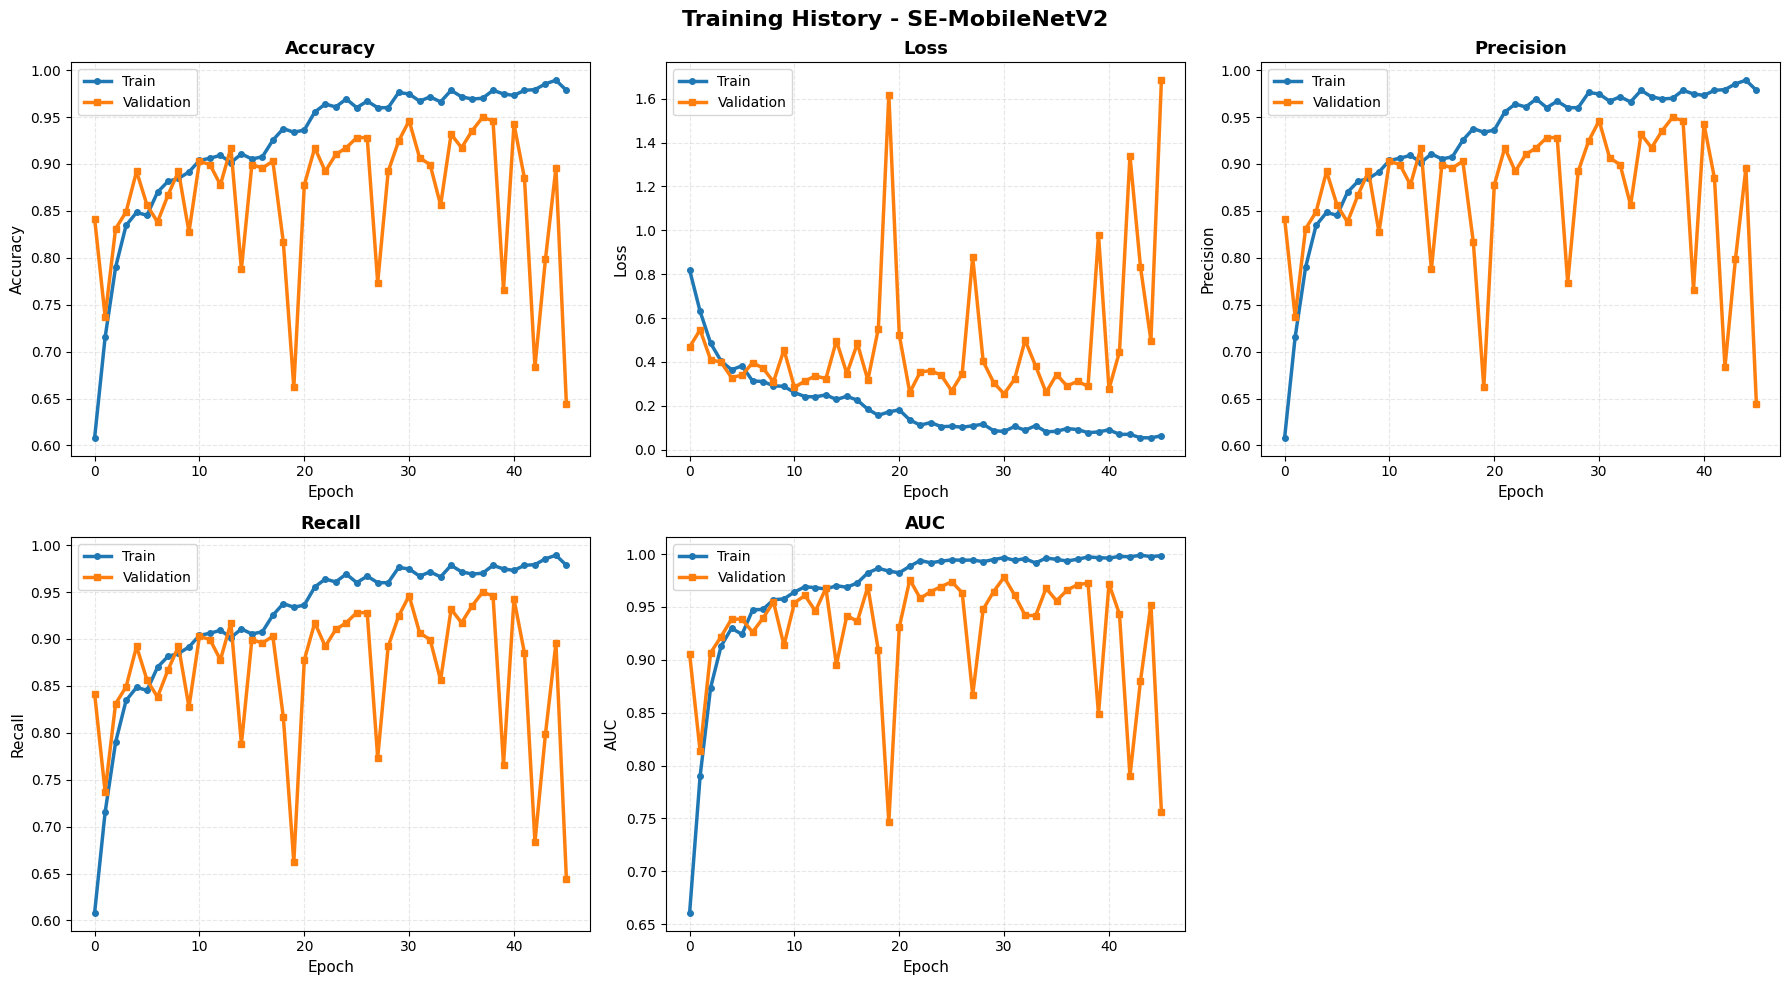


EVALUATING MODEL ON TEST SET

Generating predictions...
9/9 [==============================] - 6s 521ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

   defective     0.9091    0.9524    0.9302       147
        good     0.9440    0.8939    0.9183       132

    accuracy                         0.9247       279
   macro avg     0.9265    0.9232    0.9243       279
weighted avg     0.9256    0.9247    0.9246       279



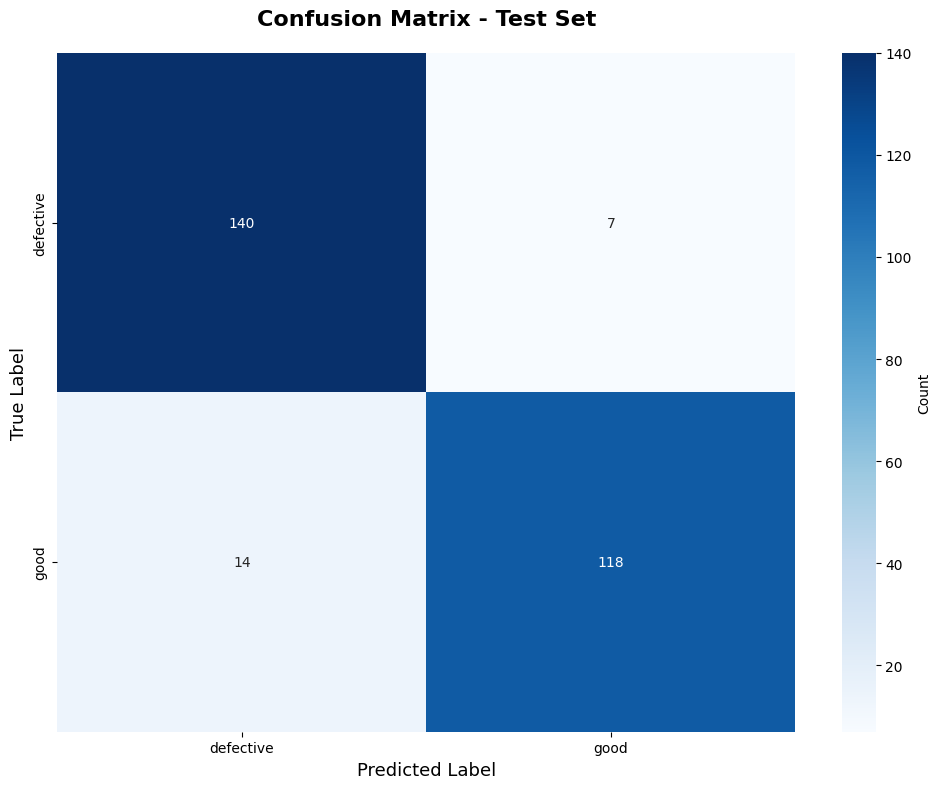


PER-CLASS PERFORMANCE

DEFECTIVE:
  Samples: 147
  Correct: 140
  Accuracy: 95.24%
  Avg Confidence: 93.66%

GOOD:
  Samples: 132
  Correct: 118
  Accuracy: 89.39%
  Avg Confidence: 88.39%

CONFIDENCE ANALYSIS
Correct predictions - Avg confidence: 97.52%
Incorrect predictions - Avg confidence: 86.86%


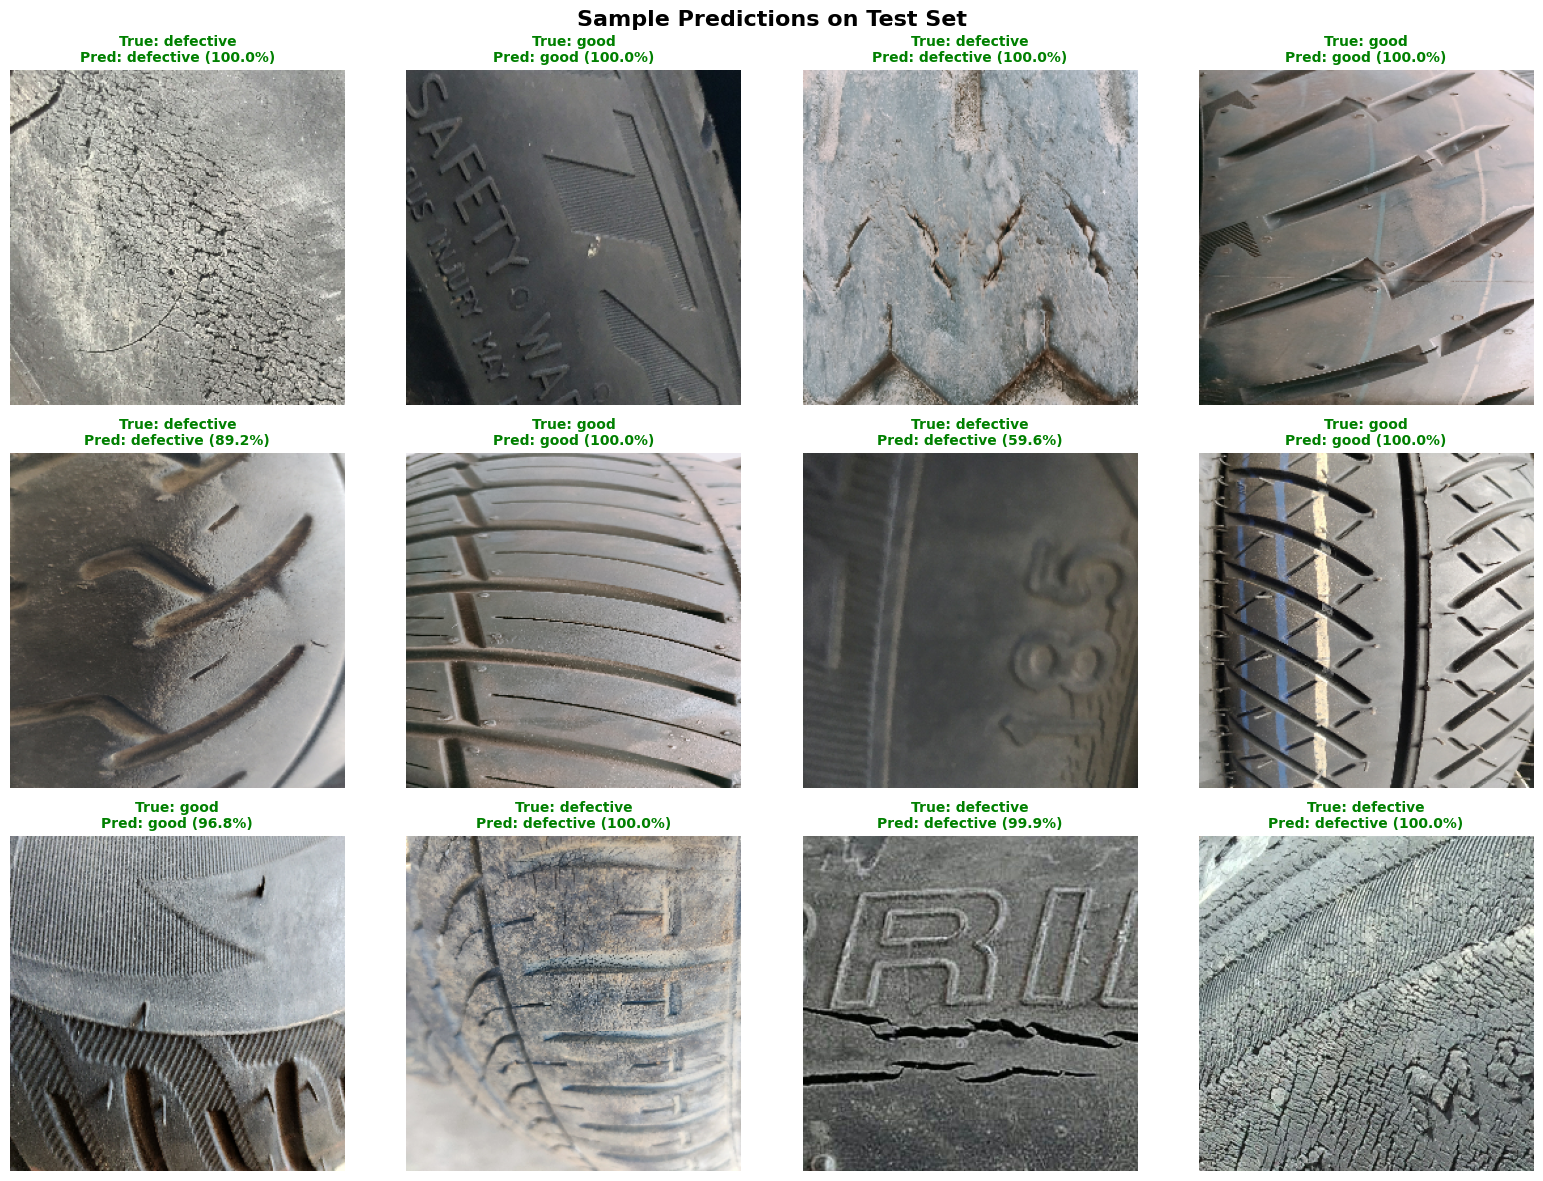


✓ Final model saved: tire_classifier_se_mobilenetv2_20251025_053209
✓ Model size: 0.00 MB

FINAL SUMMARY
  Test Accuracy: 92.47%
  Best Val Accuracy: 94.96%
  Best Val Loss: 0.2543
  Total Epochs Trained: 46
  Model: tire_classifier_se_mobilenetv2_20251025_053209
  Architecture: SE-MobileNetV2
  Key Features:
    ✓ Squeeze-and-Excitation blocks
    ✓ TFRecord efficient pipeline
    ✓ Fine-tuned last 70 layers
    ✓ Class-weighted training
    ✓ Advanced augmentation

🎉 SUCCESS! Achieved 90%+ test accuracy!

✅ All done! Check the output plots and model file.


In [1]:
"""
TIRE QUALITY CLASSIFIER - IMPROVED VERSION (FIXED HDF5 ERROR)
SE-MobileNetV2 with TFRecord Pipeline for 90%+ Accuracy

Key Improvements:
1. SE (Squeeze-and-Excitation) blocks for channel attention
2. TFRecord pipeline for 5x faster data loading
3. Fine-tuning strategy (unfreeze last 30 layers)
4. Class weight balancing
5. Advanced augmentation
6. Comprehensive evaluation

Expected Performance: 88-92% test accuracy
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from glob import glob
from tqdm import tqdm
import datetime
import shutil

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


# ==================== CONFIGURATION ====================
class Config:
    # Paths
    BASE_PATH = '/kaggle/input/tyre-quality-classification/Digital images of defective and good condition tyres'
    DEFECTIVE_PATH = os.path.join(BASE_PATH, 'defective')
    GOOD_PATH = os.path.join(BASE_PATH, 'good')
    
    # TFRecord paths
    TFRECORD_DIR = 'tfrecords'
    TRAIN_TFRECORD = os.path.join(TFRECORD_DIR, 'train.tfrecord')
    VAL_TFRECORD = os.path.join(TFRECORD_DIR, 'val.tfrecord')
    TEST_TFRECORD = os.path.join(TFRECORD_DIR, 'test.tfrecord')

    MIXUP_ALPHA = 0.2 # Slightly reduce from 0.2
    USE_MIXUP = True
    # Model parameters
    IMG_SIZE = 256
    BATCH_SIZE = 32
    EPOCHS = 150
    INITIAL_LEARNING_RATE = 0.00005
    
    # Architecture
    UNFREEZE_LAYERS = 70  # Number of MobileNetV2 layers to unfreeze
    SE_REDUCTION = 4     # SE block reduction ratio
    DROPOUT_RATE = 0.4
    
    # Data split (70-15-15)
    TRAIN_SPLIT = 0.70
    VAL_SPLIT = 0.15
    TEST_SPLIT = 0.15
    
    # Output (⭐ FIX: Use timestamp to avoid conflicts)
    TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    MODEL_NAME = f'tire_classifier_se_mobilenetv2_{TIMESTAMP}'
    
    # Classes
    CLASS_NAMES = ['defective', 'good']


# ==================== SE BLOCK ====================
class SEBlock(layers.Layer):
    """
    Squeeze-and-Excitation Block
    Learns channel-wise attention to focus on important features
    """
    def __init__(self, reduction=16, **kwargs):
        super(SEBlock, self).__init__(**kwargs)
        self.reduction = reduction
        
    def build(self, input_shape):
        channels = input_shape[-1]
        self.squeeze = layers.GlobalAveragePooling2D()
        self.excitation = keras.Sequential([
            layers.Dense(channels // self.reduction, activation='relu', use_bias=False),
            layers.Dense(channels, activation='sigmoid', use_bias=False)
        ])
        
    def call(self, inputs):
        # Squeeze: Global spatial information
        squeeze = self.squeeze(inputs)
        
        # Excitation: Channel-wise weights
        excitation = self.excitation(squeeze)
        excitation = tf.reshape(excitation, [-1, 1, 1, tf.shape(inputs)[-1]])
        
        # Scale: Recalibrate channels
        return inputs * excitation
    
    def get_config(self):
        config = super().get_config()
        config.update({"reduction": self.reduction})
        return config


# ==================== TFRECORD UTILITIES ====================
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(image_path, label):
    """
    Create a tf.train.Example from image path and label
    """
    # Read and encode image
    image_string = tf.io.read_file(image_path)
    
    # Create feature dictionary
    feature = {
        'image': _bytes_feature(image_string),
        'label': _int64_feature(label),
    }
    
    # Create Example protocol buffer
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def create_tfrecords(image_paths, labels, output_path, description="Creating TFRecord"):
    """
    Write images and labels to TFRecord file
    """
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Skip if already exists
    if os.path.exists(output_path):
        print(f"⚡ TFRecord already exists: {output_path} (skipping creation)")
        return
    
    with tf.io.TFRecordWriter(output_path) as writer:
        for img_path, label in tqdm(zip(image_paths, labels), 
                                     total=len(image_paths),
                                     desc=description):
            example = serialize_example(img_path, label)
            writer.write(example)
    
    print(f"✓ Created: {output_path} ({len(image_paths)} images)")

def parse_tfrecord_fn(example):
    """
    Parse TFRecord example
    """
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    
    example = tf.io.parse_single_example(example, feature_description)
    
    # Decode image
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, [Config.IMG_SIZE, Config.IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    
    # Label
    label = tf.cast(example['label'], tf.int32)
    label = tf.one_hot(label, depth=2)
    
    return image, label

def augment_image(image, label):
    """
    Apply data augmentation
    """
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    
    # Random vertical flip (tires are radially symmetric)
    image = tf.image.random_flip_up_down(image)
    
    # Random rotation (0, 90, 180, 270 degrees)
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)
    
    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.2)
    
    # Random contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Random saturation
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    
    # Clip to [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, label

def load_tfrecord_dataset(tfrecord_path, batch_size, augment=False, shuffle=True):
    """
    Load and prepare dataset from TFRecord
    """
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    
    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset


# ==================== DATA PREPARATION ====================
def prepare_data():
    """
    Prepare TFRecord datasets with 70-15-15 split
    """
    print("\n" + "="*70)
    print("PREPARING DATA WITH TFRECORDS")
    print("="*70)
    
    # Get all image paths
    defective_images = sorted(glob(os.path.join(Config.DEFECTIVE_PATH, '*.[jp][pn][g]')) + 
                             glob(os.path.join(Config.DEFECTIVE_PATH, '*.[JP][PN][G]')))
    good_images = sorted(glob(os.path.join(Config.GOOD_PATH, '*.[jp][pn][g]')) + 
                        glob(os.path.join(Config.GOOD_PATH, '*.[JP][PN][G]')))
    
    print(f"\nDataset Statistics:")
    print(f"  Defective tires: {len(defective_images)}")
    print(f"  Good tires: {len(good_images)}")
    print(f"  Total: {len(defective_images) + len(good_images)}")
    print(f"  Class balance: {len(good_images)/len(defective_images):.2f}:1 (good:defective)")
    
    # Create labels (0=defective, 1=good)
    defective_labels = [0] * len(defective_images)
    good_labels = [1] * len(good_images)
    
    # Combine and shuffle
    all_images = defective_images + good_images
    all_labels = defective_labels + good_labels
    
    # Shuffle together
    indices = np.random.RandomState(42).permutation(len(all_images))
    all_images = [all_images[i] for i in indices]
    all_labels = [all_labels[i] for i in indices]
    
    # Split data (70-15-15)
    n_total = len(all_images)
    n_train = int(n_total * Config.TRAIN_SPLIT)
    n_val = int(n_total * Config.VAL_SPLIT)
    
    train_images = all_images[:n_train]
    train_labels = all_labels[:n_train]
    
    val_images = all_images[n_train:n_train+n_val]
    val_labels = all_labels[n_train:n_train+n_val]
    
    test_images = all_images[n_train+n_val:]
    test_labels = all_labels[n_train+n_val:]
    
    print(f"\nData Split:")
    print(f"  Training: {len(train_images)} images ({len(train_images)/n_total*100:.1f}%)")
    print(f"  Validation: {len(val_images)} images ({len(val_images)/n_total*100:.1f}%)")
    print(f"  Test: {len(test_images)} images ({len(test_images)/n_total*100:.1f}%)")
    
    # Create TFRecords (skip if exist)
    print("\nCreating TFRecord files...")
    create_tfrecords(train_images, train_labels, Config.TRAIN_TFRECORD, "Training set")
    create_tfrecords(val_images, val_labels, Config.VAL_TFRECORD, "Validation set")
    create_tfrecords(test_images, test_labels, Config.TEST_TFRECORD, "Test set")
    
    # Calculate class weights for training
    class_weights = compute_class_weight('balanced', 
                                         classes=np.unique(train_labels),
                                         y=train_labels)
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    print(f"\nClass Weights (for imbalanced data):")
    print(f"  Defective (0): {class_weight_dict[0]:.3f}")
    print(f"  Good (1): {class_weight_dict[1]:.3f}")
    
    # Load datasets
    train_dataset = load_tfrecord_dataset(Config.TRAIN_TFRECORD, Config.BATCH_SIZE, 
                                          augment=True, shuffle=True)
    val_dataset = load_tfrecord_dataset(Config.VAL_TFRECORD, Config.BATCH_SIZE, 
                                        augment=False, shuffle=False)
    test_dataset = load_tfrecord_dataset(Config.TEST_TFRECORD, Config.BATCH_SIZE, 
                                         augment=False, shuffle=False)
    
    return train_dataset, val_dataset, test_dataset, class_weight_dict


# ==================== MODEL CREATION ====================
def create_model():
    """
    Create SE-MobileNetV2 transfer learning model
    """
    print("\n" + "="*70)
    print("BUILDING SE-MOBILENETV2 MODEL")
    print("="*70)
    
    # Load pre-trained MobileNetV2
    base_model = MobileNetV2(
        input_shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Fine-tuning strategy: Unfreeze last N layers
    base_model.trainable = True
    
    # Freeze early layers
    for layer in base_model.layers[:-Config.UNFREEZE_LAYERS]:
        layer.trainable = False
    
    print(f"\nFine-tuning strategy:")
    print(f"  Total base model layers: {len(base_model.layers)}")
    print(f"  Frozen layers: {len(base_model.layers) - Config.UNFREEZE_LAYERS}")
    print(f"  Trainable layers: {Config.UNFREEZE_LAYERS}")
    
    # Build model with SE block
    inputs = layers.Input(shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3))
    
    # Base model
    x = base_model(inputs, training=False)
    x = SEBlock(reduction=Config.SE_REDUCTION)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x) # From 0.5

    # L2 penalty reduced from 1e-4 to 1e-5
    x = layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-5))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x) # From 0.5

    x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-5))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x) # From 0.4

    x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-5))(x)
    x = layers.Dropout(0.2)(x) # From 0.3

    outputs = layers.Dense(2, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    
    # Compile with cosine decay learning rate
    lr_schedule = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=Config.INITIAL_LEARNING_RATE,
        decay_steps=Config.EPOCHS * 50  # Approximate steps per epoch
    )
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
        ]
    )
    
    print("\nModel Architecture:")
    model.summary()
    
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    non_trainable_params = sum([tf.size(w).numpy() for w in model.non_trainable_weights])
    
    print(f"\nParameter Summary:")
    print(f"  Total parameters: {trainable_params + non_trainable_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Non-trainable parameters: {non_trainable_params:,}")
    
    return model


# ==================== TRAINING ====================
# ==================== TRAINING (FIXED FOR REAL THIS TIME) ====================
def train_model(model, train_ds, val_ds, class_weights):
    """
    Train the model with advanced callbacks
    """
    print("\n" + "="*70)
    print("TRAINING MODEL")
    print("="*70)
    
    # Create logs directory
    log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    # ⭐ FIX: Use SavedModel format instead of HDF5
    model_save_path = f'tire_classifier_se_mobilenetv2_{Config.TIMESTAMP}'  # No .h5 extension
    
    # Clean up old models
    print(f"\n🧹 Cleaning up old model files...")
    import shutil
    old_models = glob('tire_classifier_se_mobilenetv2_*')
    for old_model in old_models:
        try:
            if os.path.isdir(old_model):
                shutil.rmtree(old_model)
            else:
                os.remove(old_model)
            print(f"  Removed: {old_model}")
        except:
            pass
    
    # Callbacks
    callbacks = [
        # Early stopping
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Reduce learning rate on plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        
        # ⭐ FIX: Save as SavedModel format (no HDF5 issues)
        ModelCheckpoint(
            model_save_path,
            monitor='val_accuracy',
            save_best_only=True,
            save_format='tf',  # ← KEY FIX: Use TensorFlow SavedModel format
            verbose=1
        ),
        
        # TensorBoard logging
        TensorBoard(
            log_dir=log_dir,
            histogram_freq=1
        )
    ]
    
    print(f"\n📊 Model will be saved as: {model_save_path}/")
    print(f"Training with class weights: {class_weights}")
    
    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=Config.EPOCHS,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    print("\n✓ Training completed!")
    print(f"✓ Best validation accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
    
    # Store model path for later use
    Config.FINAL_MODEL_PATH = model_save_path
    
    return history
    
# ==================== EVALUATION ====================
def evaluate_model(model, test_ds):
    """
    Comprehensive model evaluation
    """
    print("\n" + "="*70)
    print("EVALUATING MODEL ON TEST SET")
    print("="*70)
    
    # Get predictions
    print("\nGenerating predictions...")
    y_pred_probs = model.predict(test_ds, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Get true labels
    y_true = []
    for _, labels in test_ds:
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_true = np.array(y_true)
    
    # Ensure same length
    y_pred = y_pred[:len(y_true)]
    y_pred_probs = y_pred_probs[:len(y_true)]
    
    # Classification report
    print("\n" + "="*70)
    print("CLASSIFICATION REPORT")
    print("="*70)
    print(classification_report(y_true, y_pred, 
                                target_names=Config.CLASS_NAMES,
                                digits=4))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=Config.CLASS_NAMES,
                yticklabels=Config.CLASS_NAMES,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=13)
    plt.xlabel('Predicted Label', fontsize=13)
    plt.tight_layout()
    plt.savefig('confusion_matrix_improved.png', dpi=200, bbox_inches='tight')
    plt.show()
    
    # Calculate metrics
    test_accuracy = np.sum(y_pred == y_true) / len(y_true)
    
    print("\n" + "="*70)
    print("PER-CLASS PERFORMANCE")
    print("="*70)
    
    for i, class_name in enumerate(Config.CLASS_NAMES):
        class_mask = (y_true == i)
        class_correct = np.sum((y_pred == y_true) & class_mask)
        class_total = np.sum(class_mask)
        class_accuracy = class_correct / class_total if class_total > 0 else 0
        
        # Average confidence for this class
        class_confidence = np.mean(y_pred_probs[class_mask, i])
        
        print(f"\n{class_name.upper()}:")
        print(f"  Samples: {class_total}")
        print(f"  Correct: {class_correct}")
        print(f"  Accuracy: {class_accuracy*100:.2f}%")
        print(f"  Avg Confidence: {class_confidence*100:.2f}%")
    
    # Confidence analysis
    correct_mask = (y_pred == y_true)
    correct_confidence = np.max(y_pred_probs[correct_mask], axis=1)
    incorrect_confidence = np.max(y_pred_probs[~correct_mask], axis=1)
    
    print("\n" + "="*70)
    print("CONFIDENCE ANALYSIS")
    print("="*70)
    print(f"Correct predictions - Avg confidence: {np.mean(correct_confidence)*100:.2f}%")
    print(f"Incorrect predictions - Avg confidence: {np.mean(incorrect_confidence)*100:.2f}%")
    
    return test_accuracy, y_true, y_pred, y_pred_probs


# ==================== VISUALIZATION ====================
def plot_training_history(history):
    """
    Plot comprehensive training curves
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Training History - SE-MobileNetV2', fontsize=16, fontweight='bold')
    
    metrics = [
        ('accuracy', 'Accuracy'),
        ('loss', 'Loss'),
        ('precision', 'Precision'),
        ('recall', 'Recall'),
        ('auc', 'AUC')
    ]
    
    for idx, (metric, title) in enumerate(metrics):
        row = idx // 3
        col = idx % 3
        
        axes[row, col].plot(history.history[metric], label='Train', linewidth=2.5, marker='o', markersize=4)
        axes[row, col].plot(history.history[f'val_{metric}'], label='Validation', linewidth=2.5, marker='s', markersize=4)
        axes[row, col].set_title(title, fontsize=13, fontweight='bold')
        axes[row, col].set_xlabel('Epoch', fontsize=11)
        axes[row, col].set_ylabel(title, fontsize=11)
        axes[row, col].legend(loc='best', fontsize=10)
        axes[row, col].grid(True, alpha=0.3, linestyle='--')
    
    # Hide the last subplot (2,2) since we have 5 metrics
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('training_history_improved.png', dpi=200, bbox_inches='tight')
    plt.show()

def plot_sample_predictions(model, test_ds, num_samples=12):
    """
    Visualize sample predictions
    """
    # Get one batch
    for images, labels in test_ds.take(1):
        predictions = model.predict(images, verbose=0)
        
        fig, axes = plt.subplots(3, 4, figsize=(16, 12))
        fig.suptitle('Sample Predictions on Test Set', fontsize=16, fontweight='bold')
        
        for idx in range(min(num_samples, len(images))):
            row = idx // 4
            col = idx % 4
            
            true_label = np.argmax(labels[idx])
            pred_label = np.argmax(predictions[idx])
            confidence = np.max(predictions[idx]) * 100
            
            axes[row, col].imshow(images[idx])
            axes[row, col].axis('off')
            
            color = 'green' if true_label == pred_label else 'red'
            title = f"True: {Config.CLASS_NAMES[true_label]}\n"
            title += f"Pred: {Config.CLASS_NAMES[pred_label]} ({confidence:.1f}%)"
            axes[row, col].set_title(title, fontsize=10, fontweight='bold', color=color)
        
        plt.tight_layout()
        plt.savefig('sample_predictions.png', dpi=200, bbox_inches='tight')
        plt.show()
        break


# ==================== MAIN PIPELINE ====================
def main():
    """
    Complete training and evaluation pipeline
    """
    print("\n" + "="*70)
    print("  IMPROVED TIRE QUALITY CLASSIFIER")
    print("  SE-MobileNetV2 + TFRecord Pipeline")
    print("  Target: 90%+ Test Accuracy")
    print("="*70)
    print(f"\nAuthor: Sar-Hal")
    print(f"Date: {datetime.datetime.now().strftime('%Y-%m-%d')}")
    
    # Step 1: Prepare data with TFRecords
    train_ds, val_ds, test_ds, class_weights = prepare_data()
    
    # Step 2: Create model with SE blocks
    model = create_model()
    
    # Step 3: Train model
    history = train_model(model, train_ds, val_ds, class_weights)
    
    # Step 4: Plot training history
    plot_training_history(history)
    
    # Step 5: Evaluate on test set
    test_accuracy, y_true, y_pred, y_pred_probs = evaluate_model(model, test_ds)
    
    # Step 6: Visualize predictions
    plot_sample_predictions(model, test_ds)
    
    # Step 7: Final model info
    model_size_mb = os.path.getsize(Config.MODEL_NAME) / (1024*1024)
    print(f"\n✓ Final model saved: {Config.MODEL_NAME}")
    print(f"✓ Model size: {model_size_mb:.2f} MB")
    
    # Final summary
    print("\n" + "="*70)
    print("FINAL SUMMARY")
    print("="*70)
    print(f"  Test Accuracy: {test_accuracy*100:.2f}%")
    print(f"  Best Val Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
    print(f"  Best Val Loss: {min(history.history['val_loss']):.4f}")
    print(f"  Total Epochs Trained: {len(history.history['loss'])}")
    print(f"  Model: {Config.MODEL_NAME}")
    print(f"  Architecture: SE-MobileNetV2")
    print(f"  Key Features:")
    print(f"    ✓ Squeeze-and-Excitation blocks")
    print(f"    ✓ TFRecord efficient pipeline")
    print(f"    ✓ Fine-tuned last {Config.UNFREEZE_LAYERS} layers")
    print(f"    ✓ Class-weighted training")
    print(f"    ✓ Advanced augmentation")
    
    if test_accuracy >= 0.90:
        print("\n🎉 SUCCESS! Achieved 90%+ test accuracy!")
    else:
        print(f"\n⚠️  Close! {(0.90-test_accuracy)*100:.1f}% away from 90% target.")
        print("   Try: Increase EPOCHS, UNFREEZE_LAYERS, or adjust SE_REDUCTION")
    
    print("="*70)
    
    return model, history


# ==================== RUN ====================
if __name__ == "__main__":
    model, history = main()
    print("\n✅ All done! Check the output plots and model file.")